### Food Inspections - Optimizing inspections with analytics

#### Context
This is a dataset hosted by the City of Chicago. The city has an open data platform and they update their information according to the amount of data brought in.


#### Abut the data set:
This information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure. The results of the inspection are inputted into a database, then reviewed and approved by a State of Illinois Licensed Environmental Health Practitioner (LEHP).

#### Objective of this analysis :

-Over 15,000 food establishments across the city of chicago are subject to sanitation inspections by the department of public health.<br>
-A key finding of any food inspection is whether a food establishment commits a critical violation.<br>
-To predict food establishments that are likely to fail an inspection.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import metrics

from sklearn.decomposition import PCA

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#df = pd.read_csv('/content/drive/My Drive/Datasets/Food_Inspections/Food_Inspections.csv')
df = pd.read_csv('./Food_Inspections/Food_Inspections.csv')
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,08/28/2017,License,Pass,NaN,41.853651,-87.620534,"(41.853650885040594, -87.62053358114167)"
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,CHICAGO,IL,60607.0,08/28/2017,License,Not Ready,NaN,41.881572,-87.653052,"(41.88157249576794, -87.65305233593274)"
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Special Event,Risk 3 (Low),301 N JUSTINE ST,CHICAGO,IL,60607.0,08/28/2017,License Re-Inspection,Not Ready,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,41.886577,-87.665328,"(41.88657652150854, -87.66532812140231)"
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,08/28/2017,License,Pass,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.853651,-87.620534,"(41.853650885040594, -87.62053358114167)"
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,CHARTER SCHOOL,Risk 1 (High),2245 N MCVICKER AVE,CHICAGO,IL,60639.0,08/28/2017,License Re-Inspection,Pass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.921675,-87.776711,"(41.921675488910864, -87.7767113569357)"


In [8]:
df.shape

(153810, 17)

#### Null values in the dataset

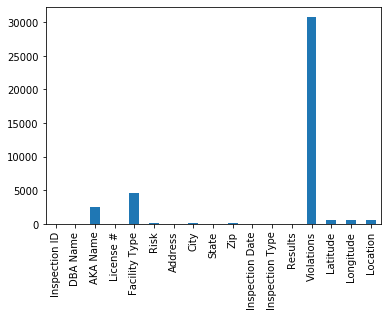

In [9]:
df.isnull().sum().plot(kind='bar')

In [10]:
(df.isnull().sum()/df.shape[0])*100

Inspection ID       0.000000
DBA Name            0.000000
AKA Name            1.653339
License #           0.009752
Facility Type       2.964697
Risk                0.042910
Address             0.000000
City                0.103374
State               0.005201
Zip                 0.063715
Inspection Date     0.000000
Inspection Type     0.000650
Results             0.000000
Violations         20.023406
Latitude            0.353683
Longitude           0.353683
Location            0.353683
dtype: float64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153810 entries, 0 to 153809
Data columns (total 17 columns):
Inspection ID      153810 non-null int64
DBA Name           153810 non-null object
AKA Name           151267 non-null object
License #          153795 non-null float64
Facility Type      149250 non-null object
Risk               153744 non-null object
Address            153810 non-null object
City               153651 non-null object
State              153802 non-null object
Zip                153712 non-null float64
Inspection Date    153810 non-null object
Inspection Type    153809 non-null object
Results            153810 non-null object
Violations         123012 non-null object
Latitude           153266 non-null float64
Longitude          153266 non-null float64
Location           153266 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 19.9+ MB


In [12]:
#Rows with null values
df[df.isnull().any(axis=1)].shape

(32855, 17)

In [13]:
#Removing all entries with Nan for Risk

#53 entries

indices_drop=df[((df['Risk'].isnull() == True) & (df['Results']!= 'Pass'))&(df['Violations'].isnull()==True)].index
df = df.drop(indices_drop)
idx = df[((df['Risk'].isnull() == True) & (df['Results']!= 'Pass'))].index
df.loc[96857,'Risk']='Risk 3 (Low)'
df[((df['Risk'].isnull() == True) & (df['Results']!= 'Pass'))]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location


In [14]:
#Risk - null ; Results - Pass
#140458 - 38 violation 
idx = df[(df['Risk'].isnull() == True)].index
df.loc[idx,'Risk']=df.loc[idx,'Risk'].fillna('Risk 1 (High)')
df.loc[140458,'Risk'] = df.loc[140458,'Risk'].replace('Risk 1 (High)','Risk 3 (Low)')

In [15]:
df.Risk.value_counts()

Risk 1 (High)      107362
Risk 2 (Medium)     31845
Risk 3 (Low)        14531
All                    19
Name: Risk, dtype: int64

In [16]:
df.Results.value_counts()

Pass                    90506
Fail                    29822
Pass w/ Conditions      14530
Out of Business         13790
No Entry                 4250
Not Ready                 806
Business Not Located       53
Name: Results, dtype: int64

In [17]:
df['Inspection Type'].value_counts().head(10)

Canvass                     81709
License                     19766
Canvass Re-Inspection       15620
Complaint                   13889
License Re-Inspection        7228
Short Form Complaint         5758
Complaint Re-Inspection      5645
Suspected Food Poisoning      702
Consultation                  662
License-Task Force            605
Name: Inspection Type, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153757 entries, 0 to 153809
Data columns (total 17 columns):
Inspection ID      153757 non-null int64
DBA Name           153757 non-null object
AKA Name           151234 non-null object
License #          153742 non-null float64
Facility Type      149241 non-null object
Risk               153757 non-null object
Address            153757 non-null object
City               153600 non-null object
State              153749 non-null object
Zip                153659 non-null float64
Inspection Date    153757 non-null object
Inspection Type    153756 non-null object
Results            153757 non-null object
Violations         123012 non-null object
Latitude           153214 non-null float64
Longitude          153214 non-null float64
Location           153214 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 26.1+ MB


In [19]:
#Changing datatype of date.
df['Inspection Date']= pd.to_datetime(df['Inspection Date']) 

In [20]:
#Data from 2010-01-04 to 2017-08-28
sorted(df['Inspection Date'],reverse=True)[:5]

[Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-08-28 00:00:00')]

In [21]:
df[df['Results']=='Out of Business']['Inspection Type'].value_counts()

Canvass                      13560
Canvass Re-Inspection           55
License                         55
Complaint                       43
Short Form Complaint            16
Complaint Re-Inspection         15
LICENSE REQUEST                 15
OUT OF BUSINESS                 14
License Re-Inspection            6
Out of Business                  5
Consultation                     3
Short Form Fire-Complaint        1
O.B.                             1
CANVASS                          1
Name: Inspection Type, dtype: int64

In [22]:
df.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name            2523
License #             15
Facility Type       4516
Risk                   0
Address                0
City                 157
State                  8
Zip                   98
Inspection Date        0
Inspection Type        1
Results                0
Violations         30745
Latitude             543
Longitude            543
Location             543
dtype: int64

In [23]:
df[df['License #'].isnull()]['License #']

578      NaN
24381    NaN
44421    NaN
69389    NaN
72405    NaN
86988    NaN
106713   NaN
110022   NaN
113446   NaN
113665   NaN
115198   NaN
124353   NaN
135567   NaN
143819   NaN
146345   NaN
Name: License #, dtype: float64

In [24]:
df['Latitude']=df['Latitude'].astype(str)
df['Longitude']=df['Longitude'].astype(str)
df['Zip']=df['Zip'].astype(str)
df['License #']=df['License #'].astype(str)
df['License #'].replace('nan','No License',inplace=True)

In [25]:
df.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name            2523
License #              0
Facility Type       4516
Risk                   0
Address                0
City                 157
State                  8
Zip                    0
Inspection Date        0
Inspection Type        1
Results                0
Violations         30745
Latitude               0
Longitude              0
Location             543
dtype: int64

In [26]:
df['State'].fillna('IL',inplace=True)

In [27]:
#No duplicate Inspection IDs
df['Inspection ID'].value_counts()[df['Inspection ID'].value_counts()!=1]

Series([], Name: Inspection ID, dtype: int64)

In [28]:
df[df['Facility Type'].isnull()]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
92,2078917,JET'S PIZZA,JET'S PIZZA,2163956.0,NaN,Risk 2 (Medium),2811 N ASHLAND AVE,CHICAGO,IL,60657.0,2017-08-23,Complaint,Fail,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.93276573571165,-87.66826200882875,"(41.93276573571165, -87.66826200882875)"
130,2078785,HOT WING JOINT,NaN,2549772.0,NaN,Risk 1 (High),1535 W 79TH ST,CHICAGO,IL,60620.0,2017-08-22,License,Not Ready,NaN,41.75026159818169,-87.66234576167015,"(41.75026159818169, -87.66234576167015)"
157,2078770,COUNTRY FOOD,COUNTRY FOOD,1195481.0,NaN,Risk 3 (Low),11300 S WENTWORTH AVE,CHICAGO,IL,60628.0,2017-08-21,Canvass,Out of Business,NaN,41.6888459802589,-87.62794434817805,"(41.688845980258904, -87.62794434817805)"
201,2078685,MAKKI MART CORP,NaN,2550262.0,NaN,All,2440 W DEVON AVE,CHICAGO,IL,60659.0,2017-08-18,License,Not Ready,NaN,41.99781439642854,-87.69150610963688,"(41.99781439642854, -87.69150610963688)"
229,2078621,TWILIGHT LOUNGE,TWILIGHT LOUNGE,67236.0,NaN,Risk 3 (Low),4644 N CENTRAL AVE,CHICAGO,IL,60630.0,2017-08-18,Canvass,Out of Business,NaN,41.965416817659744,-87.76754899426102,"(41.965416817659744, -87.76754899426102)"
255,2078569,3JJJ'S BETTER TASTE JAMAICAN JERK RESTAURANT,3JJJ'S BETTER TASTE JAMAICAN JERK RESTAURANT,2469529.0,NaN,Risk 3 (Low),409 E 103RD ST,CHICAGO,IL,60628.0,2017-08-16,License,Not Ready,NaN,41.70721220021213,-87.61336681197594,"(41.707212200212126, -87.61336681197594)"
301,2078476,STONY ISLAND DISCOUNT,STONY ISLAND DISCOUNT,2549338.0,NaN,All,1706-1708 E 79TH ST,CHICAGO,IL,60649.0,2017-08-15,License,Not Ready,NaN,41.75163004554857,-87.58285440483169,"(41.751630045548566, -87.58285440483168)"
417,2078215,MUNCHIES,NaN,2536103.0,NaN,Risk 3 (Low),3900 W MADISON ST,CHICAGO,IL,60624.0,2017-08-10,License,Not Ready,NaN,41.88086515590373,-87.72337596775058,"(41.880865155903734, -87.7233759677506)"
530,2072009,GOLDEN TEARDROPS,GOLDEN TEARDROPS,2437563.0,NaN,Risk 3 (Low),2101-2103 N CALIFORNIA AVE,CHICAGO,IL,60647.0,2017-08-08,License,Not Ready,NaN,41.919646930729,-87.69711566287607,"(41.919646930728995, -87.69711566287606)"
531,2072008,GOLDEN TEARDROPS,GOLDEN TEARDROPS,2437564.0,NaN,Risk 1 (High),2101-2103 N CALIFORNIA AVE,CHICAGO,IL,60647.0,2017-08-08,License,Not Ready,NaN,41.919646930729,-87.69711566287607,"(41.919646930728995, -87.69711566287606)"


In [29]:
idx = df[df['Facility Type'].isnull()].index
df.loc[idx,'Facility Type'] = df.loc[idx,'Facility Type'].fillna('Restaurant')

<BarContainer object of 20 artists>

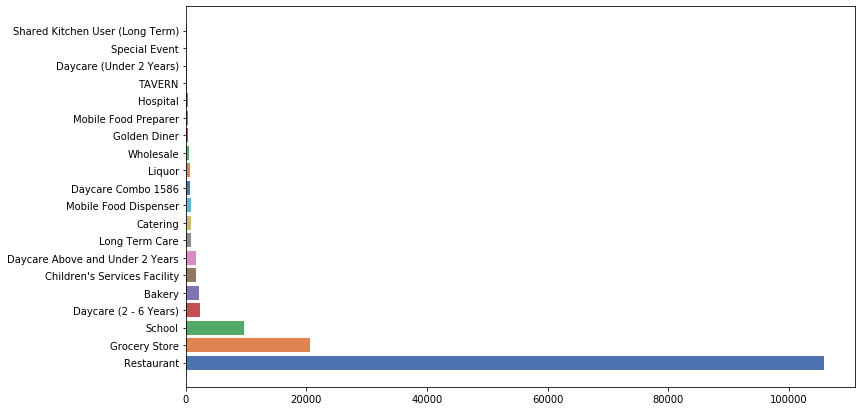

In [30]:
# Top 20 Facilities :

plt.figure(figsize=(12,7))
top_facilities=df['Facility Type'].value_counts().head(20).rename_axis('Facility Type').reset_index(name='Counts')

plt.barh(top_facilities['Facility Type'],top_facilities['Counts'],color=sns.color_palette("deep", 20))

#### Types of Risks

In [31]:
data = [
            go.Bar(
                    x = df['Risk'].value_counts().keys().tolist(),
                    y = df['Risk'].value_counts().tolist(),
                    marker = dict(
                    color = [
                                'rgb(178,34,34)', 
                                'rgb(128,128,0)',
                                'rgb(0,128,0)',
                                'rgb(255,0,255)'
                            ]
                        )
                    )
        ]

layout = go.Layout(title = 'Risks')

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'Risks')

#### Types of Facilities

In [32]:
facility_types = df['Facility Type'].value_counts().keys().tolist()
facility_count = df['Facility Type'].value_counts().tolist()
final_types = []
final_count = []
others_count = 0
one_percent = 0.01 * df.shape[0]

for count, facility_type in zip(facility_count, facility_types):
    if count > one_percent:
        final_types.append(facility_type)
        final_count.append(count)
    else:
        others_count += count

final_types.append('Others')
final_count.append(others_count)

fig = {
        "data": [{"values": final_count,
                  "labels": final_types,
                  "hoverinfo": "label+percent",
                  "hole": .5,
                  "type": "pie"
                  }],
        "layout": {"title": "Types of facilities", "width": 800,"height": 800}
      }

iplot(fig)


In [33]:
facility_types = df['Facility Type'].value_counts().keys().tolist()
facility_count = df['Facility Type'].value_counts().tolist()
one_percent = 0.01 * df.shape[0]
facility_others=[]

for count, facility_type in zip(facility_count, facility_types):
    if count < one_percent:
         facility_others.append(facility_type)

facility_others

df["Facility Type"] = np.where(df["Facility Type"].isin(facility_others),"Others",df["Facility Type"])

In [34]:
df.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name            2523
License #              0
Facility Type          0
Risk                   0
Address                0
City                 157
State                  0
Zip                    0
Inspection Date        0
Inspection Type        1
Results                0
Violations         30745
Latitude               0
Longitude              0
Location             543
dtype: int64

In [35]:
data = [
            go.Bar(
                    x = df['Results'].value_counts().keys().tolist(),
                    y = df['Results'].value_counts().tolist(),
                    marker = dict(
                    color = [
                                'rgb(0,100, 0)', 
                                'rgb(139,0,0)',
                                'rgb(0,100, 0)',
                                'rgb(139,0,0)',
                                'rgb(139,0,0)'
                            
                        
                            ]
                        )
                    )
        ]

layout = go.Layout(title = 'Inspection Results')

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'Inspections')

In [36]:
df['Results'].value_counts()

Pass                    90506
Fail                    29822
Pass w/ Conditions      14530
Out of Business         13790
No Entry                 4250
Not Ready                 806
Business Not Located       53
Name: Results, dtype: int64

#### Number of inspections - Yearly and Monthly

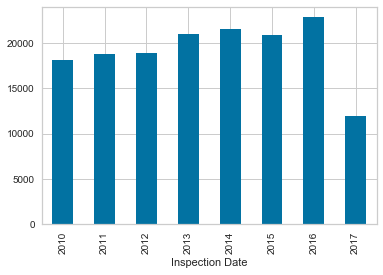

In [235]:
df.groupby(df['Inspection Date'].dt.strftime('%Y'))['Inspection ID'].count().plot(kind='bar')


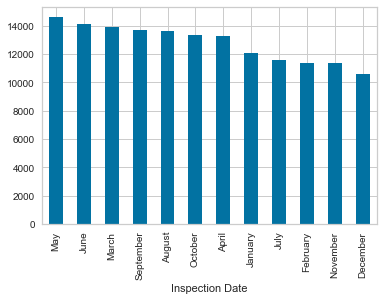

In [236]:
df.groupby(df['Inspection Date'].dt.strftime('%B'))['Inspection ID'].count().sort_values(ascending=False).plot(kind='bar')

### Feature Engineering

#### Separating Violation number from the Violation column that contains alphanumeric description of the violations committed by the facilities.

- As per the Inspection form given to the Chicago food inspectors, a facility is liable to commit violations ranging from 1 to   44 and violation 70.

- Hence I have separated out the numbers and added new columns for each violation so as to calculate the total number of times   a given facility has committed that particular violation.

In [237]:
import re
violators = df.dropna(subset=['Violations'], axis = 0, how = 'all')
violations = violators.apply(lambda row: re.findall('\|\s([0-9]+)[.]', str(row['Violations'])), axis = 1)
violations = pd.DataFrame({'Violation_nos':violations,'Inspection ID':df['Inspection ID']},columns=['Violation_nos','Inspection ID'])
print(violations)

                                            Violation_nos  Inspection ID
0                                                     NaN        2079132
1                                                     NaN        2079129
2                                                [11, 18]        2079125
3                                                    [34]        2079123
4                                        [31, 34, 38, 41]        2079105
5            [11, 21, 22, 30, 32, 33, 34, 35, 37, 38, 41]        2079104
6                                 [3, 29, 35, 33, 32, 38]        2079091
7            [21, 18, 29, 30, 34, 35, 33, 38, 32, 41, 31]        2079087
8            [19, 22, 32, 33, 34, 35, 38, 41, 43, 45, 21]        2079083
9                                                     NaN        2079036
10                                               [11, 32]        2079079
11                                                   [40]        2079076
12      [2, 3, 6, 12, 16, 30, 32, 33, 34, 35, 36, 4

In [238]:

feature_list = np.arange(1,45)
d = pd.DataFrame(0, index=np.arange(df.shape[0]), columns=feature_list)
d[70]=0
d['Inspection ID'] = df['Inspection ID']
d
df2 = df
d2 = pd.merge(df2,d,on='Inspection ID')
d2

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,36,37,38,39,40,41,42,43,44,70
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,...,0,0,0,0,0,0,0,0,0,0
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,CHICAGO,IL,60607.0,...,0,0,0,0,0,0,0,0,0,0
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Others,Risk 3 (Low),301 N JUSTINE ST,CHICAGO,IL,60607.0,...,0,0,0,0,0,0,0,0,0,0
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,...,0,0,0,0,0,0,0,0,0,0
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,CHICAGO,IL,60639.0,...,0,0,0,0,0,0,0,0,0,0
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,CHICAGO,IL,60653.0,...,0,0,0,0,0,0,0,0,0,0
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,CHICAGO,IL,60622.0,...,0,0,0,0,0,0,0,0,0,0
7,2079087,VINCENT,VINCENT,51614.0,Restaurant,Risk 1 (High),1475 W BALMORAL AVE,CHICAGO,IL,60640.0,...,0,0,0,0,0,0,0,0,0,0
8,2079083,CAPTAIN HOOKS OF DAN RYAN,CAPTAIN HOOKS OF DAN RYAN,2192934.0,Restaurant,Risk 2 (Medium),205 W 87TH ST,CHICAGO,IL,60620.0,...,0,0,0,0,0,0,0,0,0,0
9,2079036,JIBARITO'S Y MAS,JIBARITO'S Y MAS,2452249.0,Restaurant,Risk 1 (High),3400 W FULLERTON AVE,CHICAGO,IL,60647.0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
d2=pd.merge(d2,violations,on='Inspection ID')
d2

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,37,38,39,40,41,42,43,44,70,Violation_nos
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,...,0,0,0,0,0,0,0,0,0,NaN
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,CHICAGO,IL,60607.0,...,0,0,0,0,0,0,0,0,0,NaN
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Others,Risk 3 (Low),301 N JUSTINE ST,CHICAGO,IL,60607.0,...,0,0,0,0,0,0,0,0,0,"[11, 18]"
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,...,0,0,0,0,0,0,0,0,0,[34]
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,CHICAGO,IL,60639.0,...,0,0,0,0,0,0,0,0,0,"[31, 34, 38, 41]"
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,CHICAGO,IL,60653.0,...,0,0,0,0,0,0,0,0,0,"[11, 21, 22, 30, 32, 33, 34, 35, 37, 38, 41]"
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,CHICAGO,IL,60622.0,...,0,0,0,0,0,0,0,0,0,"[3, 29, 35, 33, 32, 38]"
7,2079087,VINCENT,VINCENT,51614.0,Restaurant,Risk 1 (High),1475 W BALMORAL AVE,CHICAGO,IL,60640.0,...,0,0,0,0,0,0,0,0,0,"[21, 18, 29, 30, 34, 35, 33, 38, 32, 41, 31]"
8,2079083,CAPTAIN HOOKS OF DAN RYAN,CAPTAIN HOOKS OF DAN RYAN,2192934.0,Restaurant,Risk 2 (Medium),205 W 87TH ST,CHICAGO,IL,60620.0,...,0,0,0,0,0,0,0,0,0,"[19, 22, 32, 33, 34, 35, 38, 41, 43, 45, 21]"
9,2079036,JIBARITO'S Y MAS,JIBARITO'S Y MAS,2452249.0,Restaurant,Risk 1 (High),3400 W FULLERTON AVE,CHICAGO,IL,60647.0,...,0,0,0,0,0,0,0,0,0,NaN


In [240]:
idx = d2[d2['Violation_nos'].isnull()].index
d2.loc[idx,'Violation_nos'] = d2.loc[idx,'Violation_nos'].fillna(0)

In [241]:
d2

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,37,38,39,40,41,42,43,44,70,Violation_nos
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,...,0,0,0,0,0,0,0,0,0,0
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,CHICAGO,IL,60607.0,...,0,0,0,0,0,0,0,0,0,0
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Others,Risk 3 (Low),301 N JUSTINE ST,CHICAGO,IL,60607.0,...,0,0,0,0,0,0,0,0,0,"[11, 18]"
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,...,0,0,0,0,0,0,0,0,0,[34]
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,CHICAGO,IL,60639.0,...,0,0,0,0,0,0,0,0,0,"[31, 34, 38, 41]"
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,CHICAGO,IL,60653.0,...,0,0,0,0,0,0,0,0,0,"[11, 21, 22, 30, 32, 33, 34, 35, 37, 38, 41]"
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,CHICAGO,IL,60622.0,...,0,0,0,0,0,0,0,0,0,"[3, 29, 35, 33, 32, 38]"
7,2079087,VINCENT,VINCENT,51614.0,Restaurant,Risk 1 (High),1475 W BALMORAL AVE,CHICAGO,IL,60640.0,...,0,0,0,0,0,0,0,0,0,"[21, 18, 29, 30, 34, 35, 33, 38, 32, 41, 31]"
8,2079083,CAPTAIN HOOKS OF DAN RYAN,CAPTAIN HOOKS OF DAN RYAN,2192934.0,Restaurant,Risk 2 (Medium),205 W 87TH ST,CHICAGO,IL,60620.0,...,0,0,0,0,0,0,0,0,0,"[19, 22, 32, 33, 34, 35, 38, 41, 43, 45, 21]"
9,2079036,JIBARITO'S Y MAS,JIBARITO'S Y MAS,2452249.0,Restaurant,Risk 1 (High),3400 W FULLERTON AVE,CHICAGO,IL,60647.0,...,0,0,0,0,0,0,0,0,0,0


In [242]:
for i in range(0,d2.shape[0]):
    vl = d2.loc[i,'Violation_nos']

    if type(vl) != int:
        for j in vl:
            j = int(j)
            if (j<45) | (j==70):
                d2.loc[i,j]=d2.loc[i,j]+1


In [243]:
d2.columns

Index([  'Inspection ID',        'DBA Name',        'AKA Name',
             'License #',   'Facility Type',            'Risk',
               'Address',            'City',           'State',
                   'Zip', 'Inspection Date', 'Inspection Type',
               'Results',      'Violations',        'Latitude',
             'Longitude',        'Location',                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                       8,                 9,                10,
                      11,                12,                13,
                      14,                15,                16,
                      17,                18,                19,
                      20,                21,                22,
                      23,                24,                25,
                      26,                27,                28,
                      29,               

In [244]:
cols = ['Violations','Latitude','Longitude','Location','Violation_nos','Zip','City','State']
d3 = d2.drop(cols,axis=1)
d3

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,36,37,38,39,40,41,42,43,44,70
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,0
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,2017-08-28,License,Not Ready,...,0,0,0,0,0,0,0,0,0,0
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Others,Risk 3 (Low),301 N JUSTINE ST,2017-08-28,License Re-Inspection,Not Ready,...,0,0,0,0,0,0,0,0,0,0
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,0
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,2017-08-28,License Re-Inspection,Pass,...,0,0,1,0,0,1,0,0,0,0
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,2017-08-28,License,Fail,...,0,1,1,0,0,1,0,0,0,0
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,2017-08-25,Canvass,Fail,...,0,0,1,0,0,0,0,0,0,0
7,2079087,VINCENT,VINCENT,51614.0,Restaurant,Risk 1 (High),1475 W BALMORAL AVE,2017-08-25,Complaint,Fail,...,0,0,1,0,0,1,0,0,0,0
8,2079083,CAPTAIN HOOKS OF DAN RYAN,CAPTAIN HOOKS OF DAN RYAN,2192934.0,Restaurant,Risk 2 (Medium),205 W 87TH ST,2017-08-25,Complaint Re-Inspection,Pass,...,0,0,1,0,0,1,0,1,0,0
9,2079036,JIBARITO'S Y MAS,JIBARITO'S Y MAS,2452249.0,Restaurant,Risk 1 (High),3400 W FULLERTON AVE,2017-08-25,Canvass,Out of Business,...,0,0,0,0,0,0,0,0,0,0


In [245]:
d3['Inspection Date']= pd.to_datetime(d3['Inspection Date']) 

In [246]:
d3['License #']=d3['License #'].astype(str)

#### Categorizing violations into Critical , Serious and Minor 

(As given in the Inspection form)

- 1-14 : Critical Violations
- 15-29 : Serious Violations
- 30-44 & 70 : Minor Violations

#### And, calculating the total number of critical, serious and minor violations committed by each facility (per inspection).

In [247]:
d3['CriticalCount']=d3.iloc[:,10:24].sum(axis=1)
d3['SeriousCount']=d3.iloc[:,24:39].sum(axis=1)
d3['MinorCount']=d3.iloc[:,39:54].sum(axis=1)
d3.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,39,40,41,42,43,44,70,CriticalCount,SeriousCount,MinorCount
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,0
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,2017-08-28,License,Not Ready,...,0,0,0,0,0,0,0,0,0,0
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Others,Risk 3 (Low),301 N JUSTINE ST,2017-08-28,License Re-Inspection,Not Ready,...,0,0,0,0,0,0,0,1,1,0
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,1
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,2017-08-28,License Re-Inspection,Pass,...,0,0,1,0,0,0,0,0,0,4
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,2017-08-28,License,Fail,...,0,0,1,0,0,0,0,1,2,8
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,2017-08-25,Canvass,Fail,...,0,0,0,0,0,0,0,1,1,4
7,2079087,VINCENT,VINCENT,51614.0,Restaurant,Risk 1 (High),1475 W BALMORAL AVE,2017-08-25,Complaint,Fail,...,0,0,1,0,0,0,0,0,3,8
8,2079083,CAPTAIN HOOKS OF DAN RYAN,CAPTAIN HOOKS OF DAN RYAN,2192934.0,Restaurant,Risk 2 (Medium),205 W 87TH ST,2017-08-25,Complaint Re-Inspection,Pass,...,0,0,1,0,1,0,0,0,3,7
9,2079036,JIBARITO'S Y MAS,JIBARITO'S Y MAS,2452249.0,Restaurant,Risk 1 (High),3400 W FULLERTON AVE,2017-08-25,Canvass,Out of Business,...,0,0,0,0,0,0,0,0,0,0


In [248]:
from itertools import groupby
d3.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #').head(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,39,40,41,42,43,44,70,CriticalCount,SeriousCount,MinorCount
216,2078644,ST. MARY'S CHURCH,ST. MARY'S CHURCH,0.0,Others,Risk 1 (High),4225 N CENTRAL AVE,2017-08-18,Canvass,Pass,...,0,1,0,0,1,0,0,0,0,2
146535,250567,HARVEST CRUSADES MINISTRIES,HARVEST CRUSADES MINISTRIES,1.0,Others,Risk 2 (Medium),118 N CENTRAL AVE,2010-06-04,Special Events (Festivals),Pass,...,0,0,0,0,0,0,0,0,0,0
16791,1966330,PEREZ MEXICAN FOOD,PEREZ MEXICAN FOOD,1000049.0,Restaurant,Risk 1 (High),853-855 W RANDOLPH ST,2016-10-13,Canvass Re-Inspection,Pass,...,0,0,0,0,0,0,0,0,0,3
50432,1453890,D & D FOOD & LIQUOR,D & D FOOD & LIQUOR,1000125.0,Grocery Store,Risk 3 (Low),2006 W DIVISION ST,2015-04-14,Canvass,Out of Business,...,0,0,0,0,0,0,0,0,0,0
109925,1150393,MY BOY JACK'S,MY BOY JACK'S,1000160.0,Restaurant,Risk 3 (Low),2547 W 111TH ST,2012-05-23,Canvass,Out of Business,...,0,0,0,0,0,0,0,0,0,0
143569,277994,KAPPIL STORE,KAPPIL STORE,1000200.0,Restaurant,Risk 3 (Low),5952 W DIVERSEY AVE,2010-08-04,OUT OF BUSINESS,Fail,...,0,0,0,0,0,0,0,0,0,0
57469,1441587,lakeview food mart,lakeview food mart,1000209.0,Restaurant,Risk 3 (Low),711 W BELMONT AVE,2014-12-02,Canvass,Out of Business,...,0,0,0,0,0,0,0,0,0,0
72806,1434504,DUFFY'S TAVERN & GRILLE,DUFFY'S TAVERN & GRILLE,1000245.0,Restaurant,Risk 1 (High),420 1/2 W DIVERSEY PKWY,2014-04-02,Canvass Re-Inspection,Pass,...,0,0,0,0,1,0,0,0,0,3
80645,1370098,BRIDGET MCNEILLS,BRIDGET MCNEILLS,1000325.0,Restaurant,Risk 1 (High),420 W BELMONT AVE,2013-10-30,Canvass,Out of Business,...,0,0,0,0,0,0,0,0,0,0
85195,1361284,MAS RESTAURANT,MAS RESTAURANT,1000456.0,Restaurant,Risk 3 (Low),1670 W DIVISION ST,2013-08-22,Canvass,Out of Business,...,0,0,0,0,0,0,0,0,0,0


In [249]:
from itertools import groupby
d3.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['CriticalCount'].sum()
d3.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['SeriousCount'].sum()
d3.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['MinorCount'].sum()

License #
0.0           729
1.0             0
1000049.0      52
1000125.0       0
1000160.0       0
1000200.0       0
1000209.0       0
1000245.0      65
1000325.0      22
1000456.0       0
1000572.0      77
1000612.0      29
1000639.0       6
1000774.0      41
1000849.0       0
1000878.0       0
1000894.0      34
1000918.0       0
1000971.0      18
1000978.0       7
1001031.0       0
1001133.0      15
1011.0          0
10125.0         0
10130.0         0
10139.0        17
10158.0         0
10166.0         9
10169.0         3
1017.0          0
             ... 
9586.0          1
9612.0          5
9616.0          2
9648.0         24
9655.0          0
9663.0          2
968.0          57
9691.0         16
9709.0          7
971.0           0
9731.0         36
9739.0          0
9760.0          0
980.0          89
9803.0          2
9808.0          0
9821.0         77
9829.0          0
9845.0         37
9864.0         11
9875.0          0
9886.0          0
9888.0          1
9890.0         49


In [250]:
d3.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,39,40,41,42,43,44,70,CriticalCount,SeriousCount,MinorCount
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,0
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,2017-08-28,License,Not Ready,...,0,0,0,0,0,0,0,0,0,0
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Others,Risk 3 (Low),301 N JUSTINE ST,2017-08-28,License Re-Inspection,Not Ready,...,0,0,0,0,0,0,0,1,1,0
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,1
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,2017-08-28,License Re-Inspection,Pass,...,0,0,1,0,0,0,0,0,0,4


In [251]:
d3.Results.value_counts()

Pass                    90469
Fail                    29808
Pass w/ Conditions      14528
Out of Business         13790
No Entry                 4250
Not Ready                 806
Business Not Located       53
Name: Results, dtype: int64

#### Dropping entries that have no license number :

In [252]:
idx = d3[d3['License #']=='0.0'].index
d3 = d3.drop(idx) 
d4 = d3[(d3['Results']=='Pass')|(d3['Results']=='Fail')].copy()
d4

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,39,40,41,42,43,44,70,CriticalCount,SeriousCount,MinorCount
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,0
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,1
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,2017-08-28,License Re-Inspection,Pass,...,0,0,1,0,0,0,0,0,0,4
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,2017-08-28,License,Fail,...,0,0,1,0,0,0,0,1,2,8
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,2017-08-25,Canvass,Fail,...,0,0,0,0,0,0,0,1,1,4
7,2079087,VINCENT,VINCENT,51614.0,Restaurant,Risk 1 (High),1475 W BALMORAL AVE,2017-08-25,Complaint,Fail,...,0,0,1,0,0,0,0,0,3,8
8,2079083,CAPTAIN HOOKS OF DAN RYAN,CAPTAIN HOOKS OF DAN RYAN,2192934.0,Restaurant,Risk 2 (Medium),205 W 87TH ST,2017-08-25,Complaint Re-Inspection,Pass,...,0,0,1,0,1,0,0,0,3,7
10,2079079,HAROLDS CHICKEN WEST LOOP 47,HAROLDS CHICKEN WEST LOOP 47,2543388.0,Restaurant,Risk 2 (Medium),1505 W MADISON ST,2017-08-25,License Re-Inspection,Pass,...,0,0,0,0,0,0,0,1,0,1
12,2079084,PHO 777 RESTAURANT,PHO 777 RESTAURANT,1473214.0,Restaurant,Risk 1 (High),1063-1065 W ARGYLE ST,2017-08-25,Canvass,Fail,...,0,0,1,0,0,0,0,4,1,8
13,2079073,CARNICERIA RUIZ INC,CARNICERIA RUIZ INC,31999.0,Grocery Store,Risk 1 (High),3001 N KEDZIE AVE,2017-08-25,Canvass,Pass,...,0,0,0,0,0,0,0,0,0,2


#### Calculating total number of violations (category-wise) committed by each facility over the years.

In [253]:
#from itertools import groupby
d4['TotalCritical'] = d4.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['CriticalCount'].transform('sum')
d4['TotalSerious'] = d4.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['SeriousCount'].transform('sum')
d4['TotalMinor'] = d4.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['MinorCount'].transform('sum')

In [254]:
d4.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,42,43,44,70,CriticalCount,SeriousCount,MinorCount,TotalCritical,TotalSerious,TotalMinor
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,0,0,0,0
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,Pass,...,0,0,0,0,0,0,1,0,0,1
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,2017-08-28,License Re-Inspection,Pass,...,0,0,0,0,0,0,4,1,1,8
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,2017-08-28,License,Fail,...,0,0,0,0,1,2,8,1,2,8
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,2017-08-25,Canvass,Fail,...,0,0,0,0,1,1,4,1,3,33


#### Encoding the Results field with the help of a function :

In [255]:
def result(x):
    if(x=='Pass'):
        return(1)
    else:
        return(0)

d4['Results'] = d4.Results.apply(result)

In [256]:
# Counting the number of times a facility has failed in total.

def result_fail(x):
    if(x==0):
        return(1)
    else:
        return(0)

d4['Fail_flag'] = d4.Results.apply(result_fail)

In [257]:

d4['TotalFails'] = d4.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['Fail_flag'].transform('sum')
d4['TotalPass'] = d4.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #')['Results'].transform('sum')

In [ ]:
d4.columns

In [258]:
# Taking the two major categories (Restaurant and Grocery Store) and grouping the rest into Others category.

def cat_FT(x):
    matches=['Restaurant','Grocery Store']
    if x == 'Restaurant':
         return('Restaurant')
    if x == 'Grocery Store' or x == 'Grocery':
         return('Grocery')
    if x not in matches:
         return('Others')
          
d4['Facility Type'] = d4['Facility Type'].apply(cat_FT)

In [259]:
d4['Facility Type'].value_counts()

Restaurant    79574
Others        23746
Grocery       16617
Name: Facility Type, dtype: int64

In [260]:
d4.columns

Index([  'Inspection ID',        'DBA Name',        'AKA Name',
             'License #',   'Facility Type',            'Risk',
               'Address', 'Inspection Date', 'Inspection Type',
               'Results',                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8,
                       9,                10,                11,
                      12,                13,                14,
                      15,                16,                17,
                      18,                19,                20,
                      21,                22,                23,
                      24,                25,                26,
                      27,                28,                29,
                      30,                31,                32,
                      33,                34,                35,
                      36,               

#### Dummification

In [261]:
#Dummifying the Facility Type column.

ft = pd.get_dummies(d4['Facility Type'],prefix='Facility Type')
#Adding the results to the master dataframe
d4 = pd.concat([d4,ft],axis=1)
d4

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,...,MinorCount,TotalCritical,TotalSerious,TotalMinor,Fail_flag,TotalFails,TotalPass,Facility Type_Grocery,Facility Type_Others,Facility Type_Restaurant
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,1,...,0,0,0,0,0,0,1,0,0,1
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,2017-08-28,License,1,...,1,0,0,1,0,0,1,0,0,1
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,Others,Risk 1 (High),2245 N MCVICKER AVE,2017-08-28,License Re-Inspection,1,...,4,1,1,8,0,1,1,0,1,0
5,2079104,SHRIMP'S FISH CHICKEN,SHRIMP'S FISH CHICKEN,2549497.0,Restaurant,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,2017-08-28,License,0,...,8,1,2,8,1,1,0,0,0,1
6,2079091,ART'S DRIVE INN,ART'S DRIVE INN,64682.0,Restaurant,Risk 1 (High),1333 W NORTH AVE,2017-08-25,Canvass,0,...,4,1,3,33,1,3,4,0,0,1
7,2079087,VINCENT,VINCENT,51614.0,Restaurant,Risk 1 (High),1475 W BALMORAL AVE,2017-08-25,Complaint,0,...,8,0,6,44,1,4,7,0,0,1
8,2079083,CAPTAIN HOOKS OF DAN RYAN,CAPTAIN HOOKS OF DAN RYAN,2192934.0,Restaurant,Risk 2 (Medium),205 W 87TH ST,2017-08-25,Complaint Re-Inspection,1,...,7,0,9,31,0,2,4,0,0,1
10,2079079,HAROLDS CHICKEN WEST LOOP 47,HAROLDS CHICKEN WEST LOOP 47,2543388.0,Restaurant,Risk 2 (Medium),1505 W MADISON ST,2017-08-25,License Re-Inspection,1,...,1,2,0,2,0,1,1,0,0,1
12,2079084,PHO 777 RESTAURANT,PHO 777 RESTAURANT,1473214.0,Restaurant,Risk 1 (High),1063-1065 W ARGYLE ST,2017-08-25,Canvass,0,...,8,4,6,63,1,6,8,0,0,1
13,2079073,CARNICERIA RUIZ INC,CARNICERIA RUIZ INC,31999.0,Grocery,Risk 1 (High),3001 N KEDZIE AVE,2017-08-25,Canvass,1,...,2,1,0,29,0,1,8,1,0,0


In [ ]:
#Dummifying the Risk column.

risk = pd.get_dummies(d4['Risk'],prefix='Risk')
#Adding the results to the master dataframe
risk = risk.drop('Risk_All',1)
d4 = pd.concat([d4,risk],axis=1)
d4


#### Creating a new column that would tell us about how long it has been since the last inspection (in days).

-Calculating time delta after sorting (by License and Inspection date) and grouping by License.

In [263]:
dt3 = d4.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #').head(2).copy()
dt3['SinceLastInspection'] = np.where(dt3['License #'] == dt3['License #'].shift(-1), (dt3['Inspection Date'] - dt3['Inspection Date'].shift(-1)),0) 
dt3['SinceLastInspection'] = dt3['SinceLastInspection'].dt.days

- Dataframe, d5 contains a sample of data which contains single entries only of all all establishments.
- Past data is not lost as they are captured in the new features created (e.g. count of violations, fail_flag, etc).
- This sampling technique is done to improve the imbalance present in the target class (Results). 

In [264]:
d5 = dt3.sort_values(['License #','Inspection Date'],ascending=[True,False]).groupby('License #').head(1).copy()

In [265]:
d5 = d5.drop(['Inspection ID','DBA Name','AKA Name','Address','Inspection Type','Inspection Date','Facility Type','Risk','License #'],axis=1)

In [305]:
d4.columns

Index([           'Inspection ID',                 'DBA Name',
                       'AKA Name',                'License #',
                  'Facility Type',                     'Risk',
                        'Address',          'Inspection Date',
                'Inspection Type',                  'Results',
                                1,                          2,
                                3,                          4,
                                5,                          6,
                                7,                          8,
                                9,                         10,
                               11,                         12,
                               13,                         14,
                               15,                         16,
                               17,                         18,
                               19,                         20,
                               21,                     

### Defining X and Y :

- Dataframe d4 contains original data (without grouping by License)
- Models built on d4, gave accuracy scores ranging from 70-80%
- Below results are for the sample we extracted that has only one entry for each establishment. Historic information are 
  compressed into the new columns that were created.

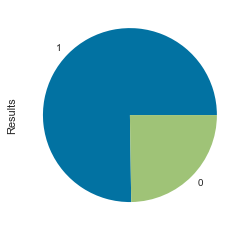

In [308]:
# Representing the imbalance present in the dataset

d4.Results.value_counts().plot(kind='pie')

So, we got ahead with the sample dataframe, d5.

In [319]:
x=d5.drop(['Results','Fail_flag'],axis=1)
#x=d4[['CriticalCount','SeriousCount','MinorCount','TotalCritical','TotalSerious','TotalMinor','Facility Type_Grocery','Facility Type_Others','Facility Type_Restaurant','Risk_Risk 1 (High)','Risk_Risk 2 (Medium)','Risk_Risk 3 (Low)']]
#x = d4.drop(['Inspection ID','DBA Name','AKA Name','Address','Inspection Type','Inspection Date','Facility Type','Risk','License #','Results','License #','Fail_flag'],axis=1)
y = d5['Results']

In [320]:
x=x[['CriticalCount','SeriousCount','MinorCount','TotalCritical','TotalSerious','TotalMinor','TotalPass','TotalFails',
      'Facility Type_Grocery','Facility Type_Others','Facility Type_Restaurant','Risk_Risk 1 (High)','Risk_Risk 2 (Medium)',
      'Risk_Risk 3 (Low)', 'SinceLastInspection']]

In [321]:
#Scaling the data to bring them all on the same scale.

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [270]:
# Loading all the required packages for model building.

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from yellowbrick.classifier import ClassificationReport

In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier

In [ ]:
# Splitting the data into train and test data in 70:30 ratio.

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.30,random_state=123)


#### Decision Tree Model

In [323]:
#Decision Tree Model

dtree=DecisionTreeClassifier(criterion='entropy')
dtree.fit(xtrain,ytrain)
pred=dtree.predict(xtest)
table=confusion_matrix(ytest,pred)
print(table)
accuracy_score(ytest,pred)


[[ 396   80]
 [  85 7773]]


0.9802015838732901

#### Logistic Regression Model

In [274]:
# Log Reg Model

from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lgmodel = lg.fit(xtrain,ytrain).predict(xtest)
print(accuracy_score(ytest,lgmodel))
print(cohen_kappa_score(ytest,lgmodel))

0.9456443484521239
0.23712624702199936


In [275]:
d5.Results.value_counts()

1    26138
0     1641
Name: Results, dtype: int64

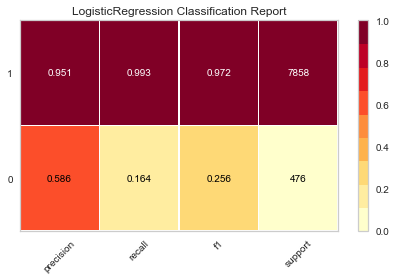

In [276]:
#Classification Report 

classes = ['0','1']
visualizer = ClassificationReport(lg, classes=classes, support=True)

visualizer.fit(xtrain, ytrain)  # Fit the visualizer and the model
visualizer.score(xtest, ytest)  # Evaluate the model on the test data
visualizer.poof()  

#### KNN Model

In [277]:
# KNN Model

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
pred_knn = knn.fit(xtrain,ytrain).predict(xtest)
print(accuracy_score(ytest,pred_knn))
print(cohen_kappa_score(ytest,pred_knn))

0.9664026877849772
0.6179420160962342


#### Random Forest Classifier Model

In [278]:
#RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

rf = RandomForestClassifier(criterion="entropy")
rfmodel = rf.fit(xtrain,ytrain).predict(xtest)
print(accuracy_score(ytest,rfmodel))
print(cohen_kappa_score(ytest,rfmodel))

0.980441564674826
0.8067791344985588


#### Bagging Classifier Model

In [279]:
# Bagging Classifier Model

from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()

pred_bc = bc.fit(xtrain,ytrain).predict(xtest)

print(accuracy_score(ytest,pred_bc))
print(cohen_kappa_score(ytest,pred_bc))

0.9802015838732901
0.8115323646369252


#### AdaBoostClassifier Model

In [280]:
# AdaBoostClassifier Model

from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()

pred_ada = ada.fit(xtrain,ytrain).predict(xtest)

print(accuracy_score(ytest,pred_ada))
print(cohen_kappa_score(ytest,pred_ada))

0.9772018238540917
0.7609692740769725


#### AdaBoostClassifier Model with Random Forest

In [281]:

# AdaBoostClassifier Model with Random Forest
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=rf)

pred_ada = ada.fit(xtrain,ytrain).predict(xtest)

print(accuracy_score(ytest,pred_ada))
print(cohen_kappa_score(ytest,pred_ada))

0.9796016318694505
0.79170121699488


#### Gradient Boosting Classifier Model

In [282]:

# GradientBoostingClassifier Model
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

pred_gbm = gb.fit(xtrain,ytrain).predict(xtest)

print(accuracy_score(ytest,pred_gbm))
print(cohen_kappa_score(ytest,pred_gbm))

table=confusion_matrix(ytest,pred)
print(table)

0.9839212862970962
0.8350956506536187
[[ 362  114]
 [ 127 7731]]


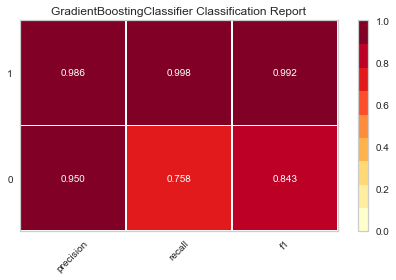

In [283]:
classes = ['0','1']
visualizer = ClassificationReport(gb, classes=classes, support=False)

visualizer.fit(xtrain, ytrain)  # Fit the visualizer and the model
visualizer.score(xtest, ytest)  # Evaluate the model on the test data
visualizer.poof()  

In [284]:
tn, fp, fn, tp = confusion_matrix(ytest,pred).ravel()
print(tn, fp, fn, tp)

362 114 127 7731


In [285]:
TP = table[1,1] # true positive 
TN = table[0,0] # true negatives
FP = table[0,1] # false positives
FN = table[1,0] # false negatives
print(TN,FP,FN,TP)

362 114 127 7731


In [286]:
#sensitivity
TP / float(TP+FN)

0.9838381267498091

In [287]:
#specificity
TN / float(TN+FP)

0.7605042016806722

In [288]:
#False Positive Rate
print(FP/ float(TN+FP))
# positive predictive value 
print (TP / float(TP+FP))
# Negative predictive value
print (TN / float(TN+ FN))

0.23949579831932774
0.9854684512428298
0.7402862985685071


#### XG Boost Model

In [299]:
#XG Boost Model

import xgboost as xgb
xgb = xgb.XGBClassifier()

pred_xgb = xgb.fit(xtrain,ytrain).predict(xtest)

print(accuracy_score(ytest,pred_xgb))
print(cohen_kappa_score(ytest,pred_xgb))

0.9631629469642429
0.5280528174560866


In [300]:
import xgboost as xgb
xgb = xgb.XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

pred_xgb = xgb.fit(xtrain,ytrain).predict(xtest)

print(accuracy_score(ytest,pred_xgb))
print(cohen_kappa_score(ytest,pred_xgb))


0.9691624670026397
0.6410832263930695


#### Voting Classifier Model

In [303]:

# Voting Classifier Model
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators=[("lg", lg), ("rf", rf),("knn", knn), 
                                  ("tree", dtree),("gbm",gb),("ada",ada)])


pred_vc = vc.fit(xtrain,ytrain).predict(xtest)
print(accuracy_score(ytest,pred_vc))
print(cohen_kappa_score(ytest,pred_vc))

0.9704823614110871
0.6714817711004


In [ ]:
# Checking the feature importance (from the Random Forrest model)

features = pd.DataFrame(rf.feature_importances_, index = xtrain.columns, columns=['Features']).sort_values('Features',ascending=False)
features

In [ ]:
#Applying 5 fold cross validation and comparing results.

model = xgb
from sklearn import model_selection
scoring = 'recall'

kfold = model_selection.KFold(n_splits=5,random_state=2)
cv_results = model_selection.cross_val_score(model, x, y, cv=kfold) 
cv_results

### Comparison of all algorithms:

LR: 0.944994 (0.017400)
KNN: 0.966917 (0.006480)
CART: 0.970121 (0.009064)
RF: 0.979949 (0.005976)
BagC: 0.978905 (0.006508)
ADA: 0.976781 (0.006232)
GB: 0.982793 (0.006210)
XGB: 0.983333 (0.006297)
VC: 0.982685 (0.005896)


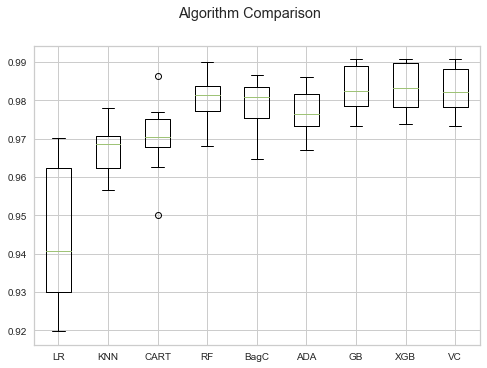

In [200]:

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('BagC', BaggingClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XGB', xgb))
models.append(('VC', VotingClassifier(estimators=[("lg", lg), ("rf", rf),("knn", knn),("tree", dtree),("gbm",gb),("ada",ada)])))

# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=12345)
	cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# Boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### ROC Curve

In [130]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs ) #auc - Area Under the Curve
    
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

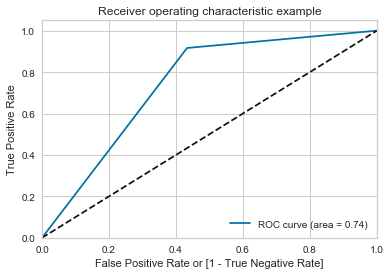

(array([0.        , 0.43308304, 1.        ]),
 array([0.        , 0.91643764, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [131]:
draw_roc(y_pred_final.Results, y_pred_final.predicted)

In [289]:
# Predicted probabilities
y_pred = gb.predict_proba(xtest)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Converting y_test to dataframe
y_test_df = pd.DataFrame(ytest)

In [ ]:
# Putting CustID to index
y_test_df['ID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Pass_Prob'})
y_pred_final

In [291]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['ID','Results','Pass_Prob'], axis=1)

In [292]:
y_pred_final.head()

,ID,Results,Pass_Prob
0,19571,1,0.995291
1,8225,1,0.989695
2,18938,0,0.892279
3,14226,1,0.763788
4,15024,1,0.978701


In [293]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Pass_Prob.map( lambda x: 1 if x > 0.5 else 0)
y_pred_final.head()

,ID,Results,Pass_Prob,predicted
0,19571,1,0.995291,1
1,8225,1,0.989695,1
2,18938,0,0.892279,1
3,14226,1,0.763788,1
4,15024,1,0.978701,1


### PCA for dimesionality reduction :

In [294]:
#PCA

pca= PCA(n_components=10)
pca_mod2 = pca.fit_transform(x)
np.cumsum(pca.explained_variance_ratio_)


array([0.25274524, 0.42189717, 0.53780996, 0.63000722, 0.72053203,
       0.79047025, 0.8544729 , 0.9031366 , 0.94528601, 0.97284772])

In [295]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.152136,0.173840,-0.016606,0.610185,-0.057173,0.388014
1,0.231689,0.232279,-0.038749,0.443564,-0.030739,0.021830
2,0.281332,0.107057,-0.055733,-0.032460,-0.100440,0.262369
3,0.357090,0.179079,0.040740,0.131330,0.016029,0.070914
4,0.430791,0.200501,0.026666,-0.069475,0.073987,-0.149744


In [296]:
PCA_df = pd.DataFrame(pca_mod2)
xtrain, xtest, ytrain, ytest = train_test_split(PCA_df, y, test_size=0.30, random_state=1)

pred_gbm_pca = gb.fit(xtrain,ytrain).predict(xtest)
print(accuracy_score(ytest,pred_gbm_pca))
print(cohen_kappa_score(ytest,pred_gbm_pca))



0.9628029757619391
0.535459523840348


In [297]:
#x=d5.drop(['Inspection ID','DBA Name','AKA Name','Address','Inspection Type','Inspection Date','Facility Type','Risk','Results','TotalPass','TotalFails','License #','Fail_flag'],axis=1)
#x=dt3[['CriticalCount','SeriousCount','MinorCount','TotalCritical','TotalSerious','TotalMinor','Facility Type_Grocery','Facility Type_Others','Facility Type_Restaurant','Risk_Risk 1 (High)','Risk_Risk 2 (Medium)','Risk_Risk 3 (Low)']]

x = sc.fit_transform(x)
#Building a covariance matrix.
cov_matrix = np.cov(x.T)
#Finding the Eigen Values and Eigen Vectors
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
eigen_pairs = [(np.abs(eig_vals[i]), eig_vecs[ :, i]) for i in range(len(eig_vals))]

#Calculating the cumulative variance explained by the components.
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)] # Normalizing (pdf)
cum_var_exp = np.cumsum(var_exp) #Calculating the cumulative sum (cdf)
print("Cumulative Variance Explained", cum_var_exp) 

Cumulative Variance Explained [ 25.27452391  42.18971683  53.78099645  63.0007217   72.0532028
  79.0470245   85.44728996  90.3136604   94.52860103  97.28477191
  98.73514322  99.99817254 100.         100.        ]


### Representation of the components and the variance explained by them.

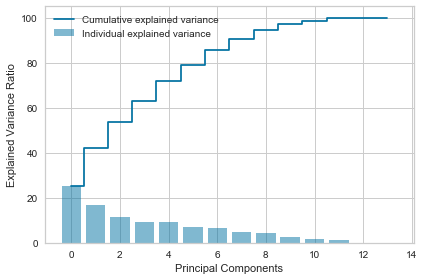

In [298]:
plt.figure(figsize=(6 , 4))
plt.bar(range(14), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(14), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()